In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import ast
import sklearn
import regex as re
import matplotlib.patches as mpatches


In [118]:
means = pd.read_csv("cofactor_expression/mean_expression.csv").set_index("tissueSiteDetailId").T
medians = pd.read_csv("cofactor_expression/median_expression.csv").set_index("tissueSiteDetailId").T
stds = pd.read_csv("cofactor_expression/std_expression.csv").set_index("tissueSiteDetailId").T
counts = pd.read_csv("cofactor_expression/counts_expression.csv").set_index("tissueSiteDetailId")
GTEXmapper = pd.read_csv("helperfiles/mapper_GTEXcode.csv")
cofactors = pd.read_csv("helperfiles/cofactors_mapped_combined.csv")

In [119]:
#Remove tissues where sample count < 100
tissues_less100 = counts[counts["ENSG00000156603.15"] < 100].index.to_list()
medians = medians.drop(tissues_less100, axis=1)
means = means.drop(tissues_less100, axis=1)

In [120]:
cofactors_select = cofactors[["Gene Name", "Complex", "Subcomplex or Module", "UniprotID"]]
merged = cofactors_select.merge(GTEXmapper, on="UniprotID")
merged.head()

,Gene Name,Complex,Subcomplex or Module,UniprotID,Bgee,GeneID,Gene Names,GTEXGeneCode
0,BAF180,BAF,esBAF,Q86U86,ENSG00000163939,55193.0,"['PBRM1', 'BAF180', 'PB1']",ENSG00000163939.18
1,BAF180,BAF,npBAF,Q86U86,ENSG00000163939,55193.0,"['PBRM1', 'BAF180', 'PB1']",ENSG00000163939.18
2,BAF180,BAF,nBAF,Q86U86,ENSG00000163939,55193.0,"['PBRM1', 'BAF180', 'PB1']",ENSG00000163939.18
3,BCL11A,BAF,esBAF,Q9H165,ENSG00000119866,53335.0,"['BCL11A', 'CTIP1', 'EVI9', 'KIAA1809', 'ZNF856']",ENSG00000119866.20
4,BCL11A,BAF,npBAF,Q9H165,ENSG00000119866,53335.0,"['BCL11A', 'CTIP1', 'EVI9', 'KIAA1809', 'ZNF856']",ENSG00000119866.20


In [121]:
#Identifying genes with multiple entries due to gene name redundancy
GTEXmappermain = merged[["GTEXGeneCode", "Gene Name", "Complex", "Subcomplex or Module"]]
grouped = GTEXmappermain.groupby("GTEXGeneCode").agg(list)
grouped_count = GTEXmappermain.groupby("GTEXGeneCode").agg(len)
grouped[grouped_count["Gene Name"] > 1]

GTEXmappermain = merged[["GTEXGeneCode", "Gene Name", "Complex", "Subcomplex or Module"]]
grouped = GTEXmappermain.groupby("GTEXGeneCode").agg(lambda x: list(set(x.to_list())))
grouped["Gene Name"] = grouped["Gene Name"].apply(lambda x: x[0])

def flatten_and_clean(input_list):
    output_list = []
    
    for item in input_list:
        # If the item is a list, recursively flatten it
        if isinstance(item, list):
            output_list.extend(flatten_and_clean(item))  # Recursion to flatten sublists
        # If the item is NaN, skip it
        elif isinstance(item, float) and math.isnan(item):
            continue
        else:
            output_list.append(item.replace("[", "").replace("]", ""))
        
    return output_list

grouped["Subcomplex or Module"] = grouped["Subcomplex or Module"].apply(flatten_and_clean)

genename = grouped[["Gene Name"]]
medians_gene = np.log(medians.merge(genename, left_index=True, right_index=True).set_index("Gene Name"))
means_gene = np.log(means.merge(genename, left_index=True, right_index=True).set_index("Gene Name"))
stds_gene = stds.merge(genename, left_index=True, right_index=True).set_index("Gene Name")

In [122]:
#Sort columns adn rows highest to lowest
medians = pd.read_csv("cofactor_expression/median_expression.csv").set_index("tissueSiteDetailId")

medians_gene["Net"] = medians_gene.sum(axis=1)
medians_gene = medians_gene.sort_values("Net").drop("Net", axis = 1)
medians_gene.head()

,Thyroid,Testis,Small_Intestine_Terminal_Ileum,Skin_Not_Sun_Exposed_Suprapubic,Brain_Frontal_Cortex_BA9,Vagina,Whole_Blood,Brain_Amygdala,Pituitary,Minor_Salivary_Gland,...,Adipose_Visceral_Omentum,Brain_Nucleus_accumbens_basal_ganglia,Brain_Cerebellar_Hemisphere,Esophagus_Mucosa,Cells_Cultured_fibroblasts,Artery_Aorta,Brain_Putamen_basal_ganglia,Lung,Brain_Substantia_nigra,Skin_Sun_Exposed_Lower_leg
Gene Name,,,,,,,,,,,,,,,,,,,,,
MED12L,-0.611594,1.291163,-1.751467,-1.839829,0.547484,-0.412772,-1.170979,-0.057714,0.875631,-1.184467,...,-1.978371,0.170637,0.830473,-1.968794,-2.157260,-1.409039,-0.274991,-1.215258,-0.249820,-1.828705
BAF53B,-2.442370,0.936985,-0.973534,-2.932084,4.136678,-1.568729,-3.302368,2.973801,3.667329,-3.482861,...,-3.391318,3.758403,4.826325,-3.210383,-3.594699,-3.151180,3.380787,-2.720991,2.397945,-2.575144
BAF45B,-2.309640,1.590806,-1.838646,-0.983742,3.395952,-1.717247,-3.613999,2.559148,1.376940,-2.708164,...,-1.894224,2.963357,2.723904,-2.185961,0.981892,0.605620,2.424504,-0.528791,1.637734,-0.770381
BCL11B,0.655395,0.273720,1.928754,3.142664,1.218815,1.795173,1.524378,1.483627,-0.736119,1.118492,...,-0.175055,2.782053,-1.896056,1.955016,-1.083235,-0.954686,2.336865,0.944884,-0.559906,3.118864
BCL11A,0.237475,0.136160,1.932353,2.742502,2.387512,1.915500,0.189820,0.685463,0.348277,1.530878,...,-1.836611,1.953564,-0.832854,2.186761,-1.365548,-2.580545,1.812241,-0.297743,0.384418,2.670931


In [123]:
medians_gene = medians_gene.T
medians_gene["Net"] = medians_gene.sum(axis=1)
medians_gene = medians_gene.sort_values("Net").drop("Net", axis = 1)
medians_gene = medians_gene.T
medians_gene.head()

,Heart_Left_Ventricle,Liver,Pancreas,Whole_Blood,Heart_Atrial_Appendage,Brain_Putamen_basal_ganglia,Brain_Amygdala,Brain_Substantia_nigra,Brain_Hippocampus,Brain_Caudate_basal_ganglia,...,Vagina,Brain_Cerebellum,Cells_Cultured_fibroblasts,Thyroid,Brain_Cerebellar_Hemisphere,Nerve_Tibial,Cells_EBV-transformed_lymphocytes,Ovary,Uterus,Testis
Gene Name,,,,,,,,,,,,,,,,,,,,,
MED12L,-2.683578,-3.537102,-2.887692,-1.170979,-1.815680,-0.274991,-0.057714,-0.249820,-0.282657,0.163781,...,-0.412772,0.831281,-2.157260,-0.611594,0.830473,0.286133,-0.872018,-0.999966,-0.062460,1.291163
BAF53B,-3.929356,-3.005083,-0.717928,-3.302368,-3.453862,3.380787,2.973801,2.397945,3.090538,3.521083,...,-1.568729,4.767309,-3.594699,-2.442370,4.826325,-2.839371,-3.248787,-2.231577,-3.185519,0.936985
BAF45B,-1.675923,-3.883352,-2.792813,-3.613999,-1.530129,2.424504,2.559148,1.637734,2.668494,2.527784,...,-1.717247,2.709516,0.981892,-2.309640,2.723904,-1.466564,-0.154205,-0.739380,-0.841544,1.590806
BCL11B,-2.917501,-1.371438,-2.225458,1.524378,-1.952894,2.336865,1.483627,-0.559906,1.674500,2.476073,...,1.795173,-2.264940,-1.083235,0.655395,-1.896056,-1.182970,-2.340836,-0.784280,-1.109120,0.273720
BCL11A,0.261290,-2.765942,0.130183,0.189820,-0.772362,1.812241,0.685463,0.384418,2.027784,1.958774,...,1.915500,-0.179442,-1.365548,0.237475,-0.832854,-2.330144,1.871559,-1.244251,-0.297451,0.136160


# Cluster Maps

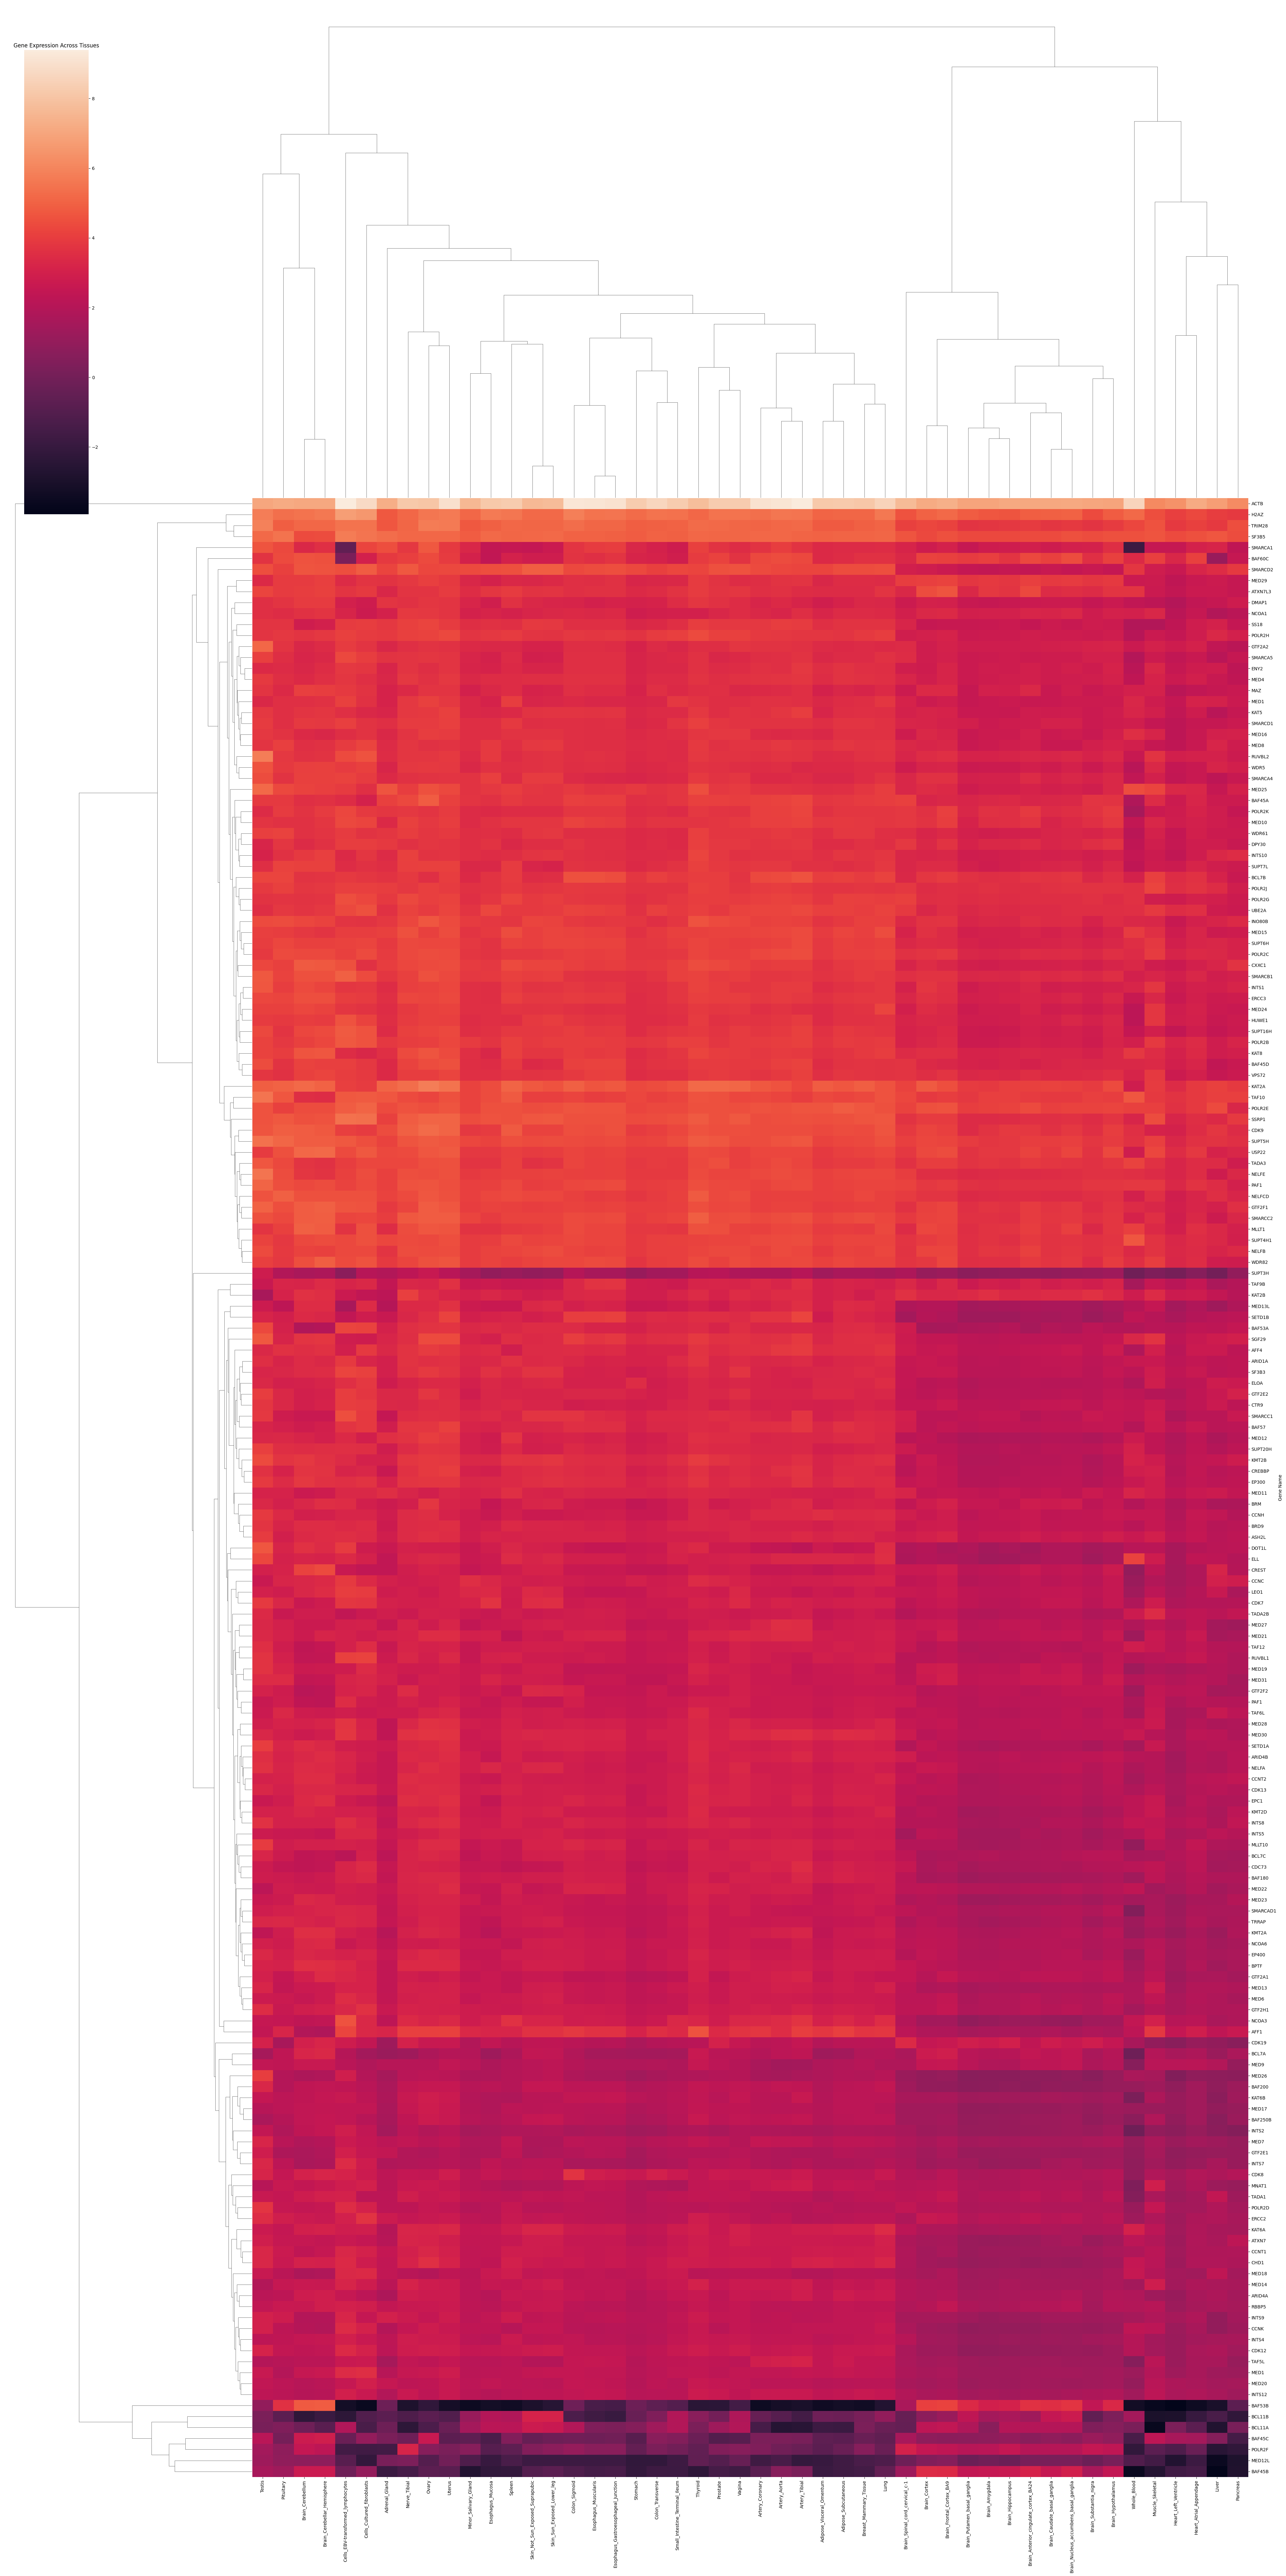

In [124]:
sns.clustermap(medians_gene, figsize=(40, 80))
plt.title("Gene Expression Across Tissues")
plt.savefig("figures/mediangeneexpression.png")

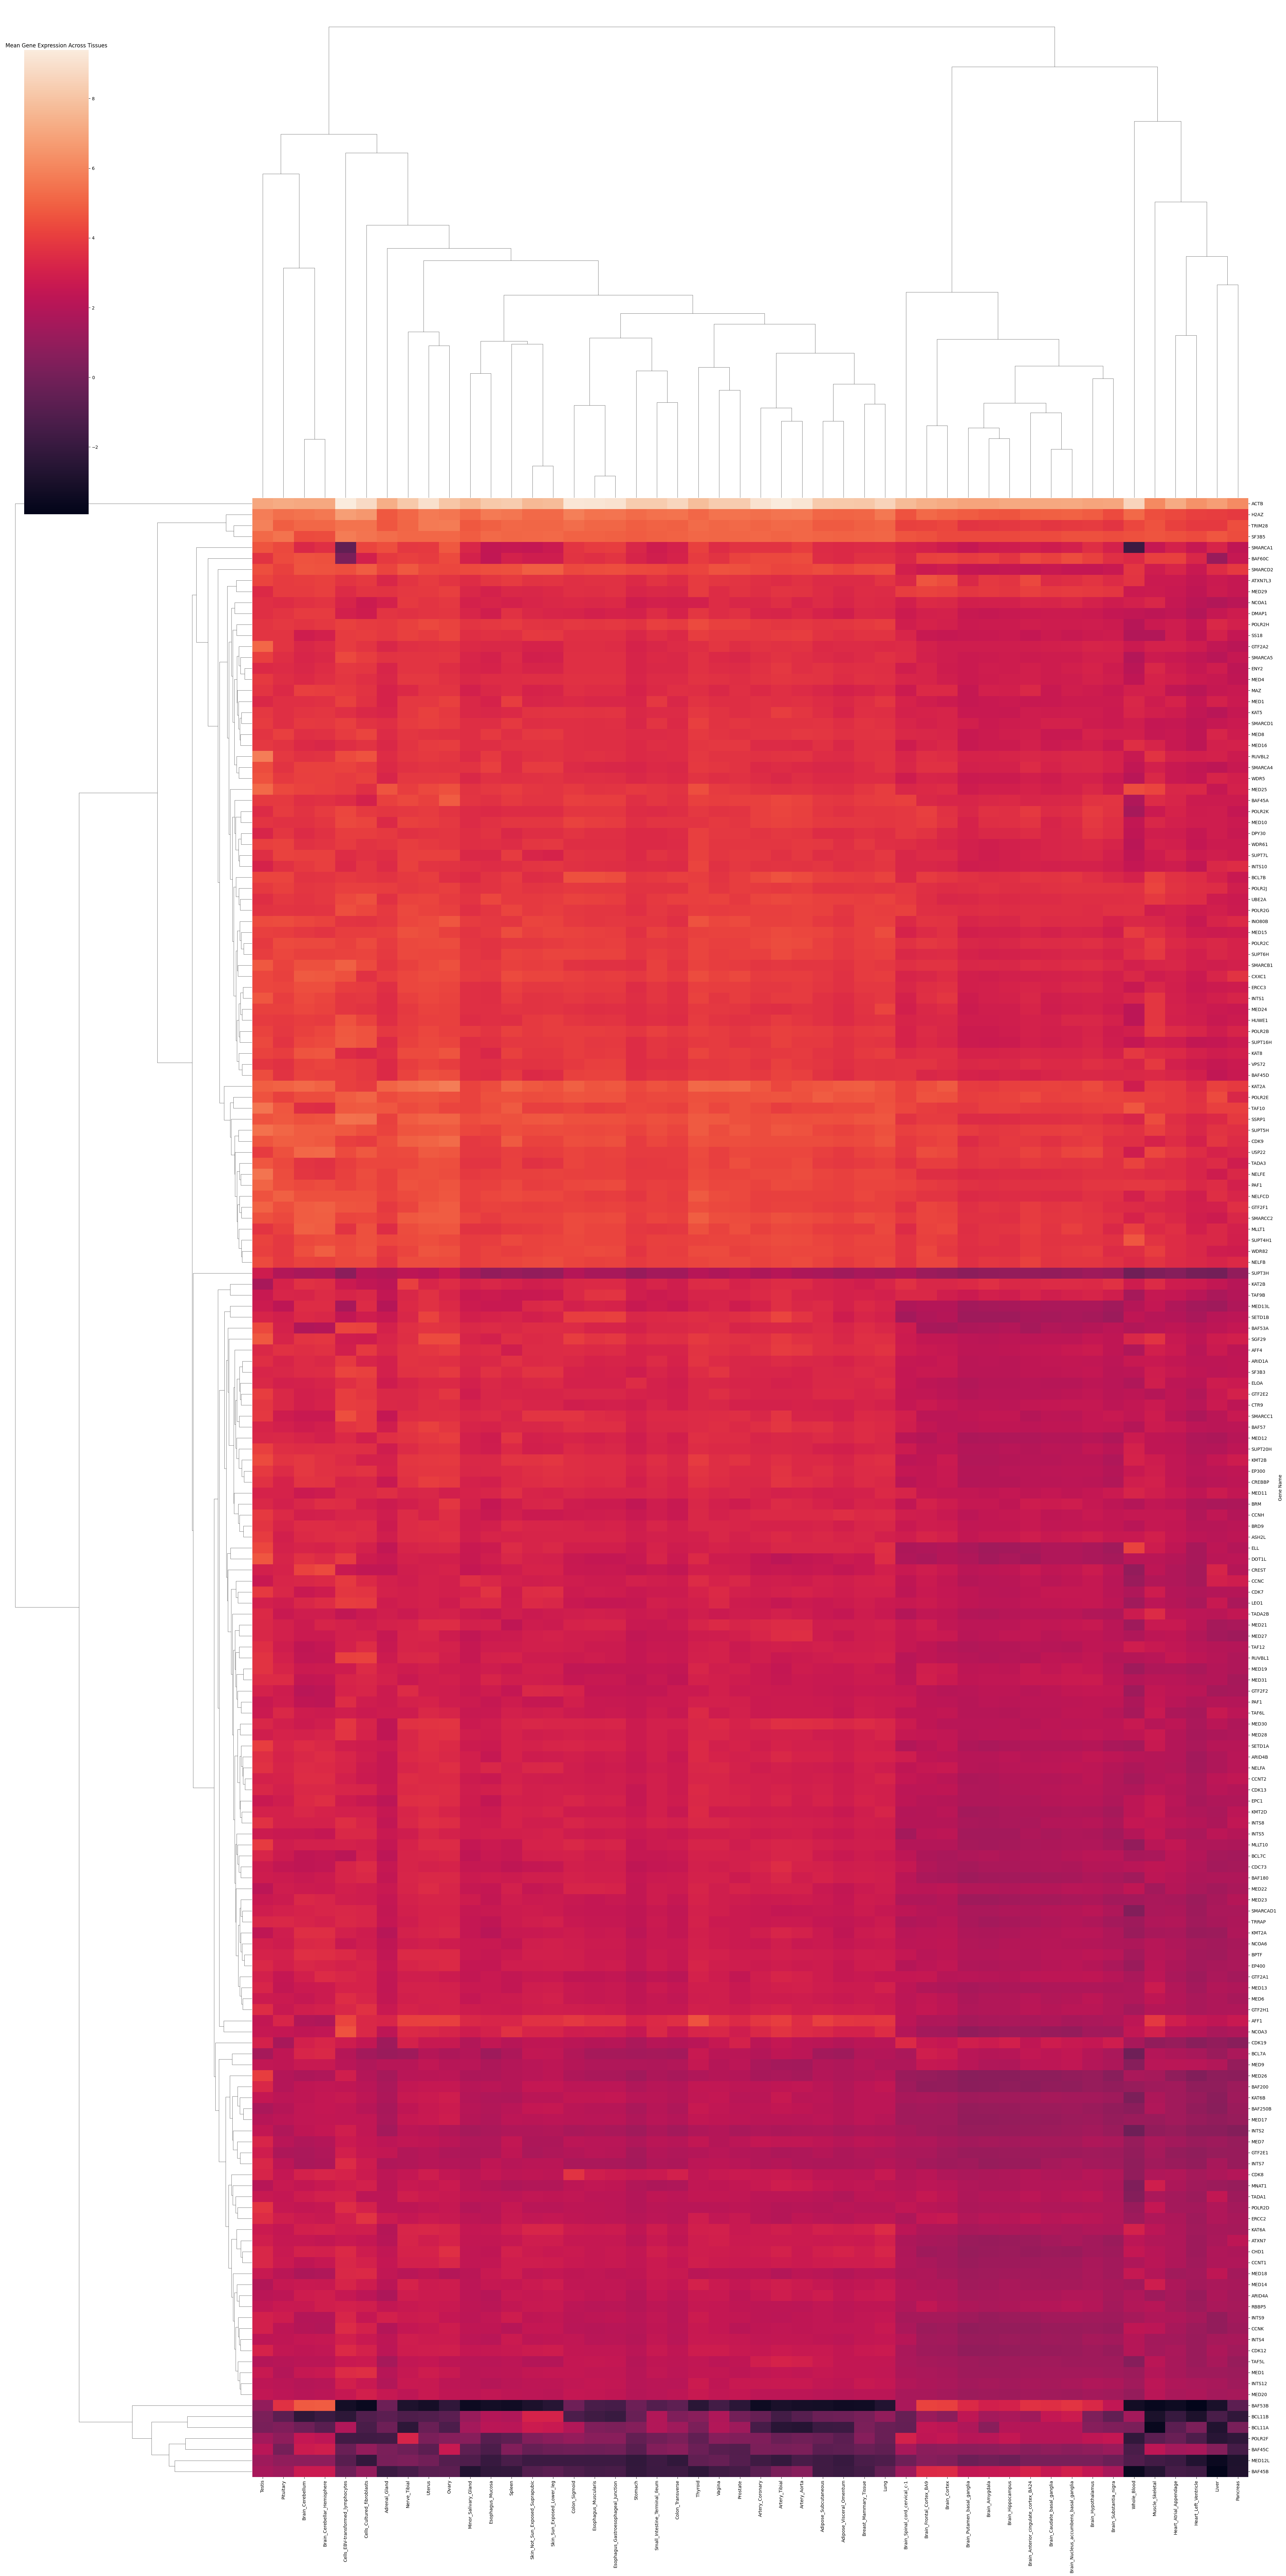

In [125]:
sns.clustermap(means_gene, figsize=(40, 80))
plt.title("Mean Gene Expression Across Tissues")
plt.savefig("figures/meangeneexpression.png")

In [159]:
#Some genes are in multiple complexes (due to more generic classification in "other.csv") -- this ensures each complex is only in one complex
multicomplex = grouped[[len(complex) > 1 for complex in grouped["Complex"]]]
grouped_single_complex = grouped.copy()[["Gene Name", "Complex"]]
grouped_single_complex.loc[multicomplex.index.to_list(), "Complex"] = multicomplex["Complex"].apply(lambda x: x[1])
grouped_single_complex["Complex"] = [val[0] if (isinstance(val, list) or isinstance(val, pd.Series)) else val for val in grouped_single_complex["Complex"]]
grouped_single_complex = grouped_single_complex.drop_duplicates()
grouped_single_complex = grouped_single_complex.set_index("Gene Name")


def get_one_complex(genename):
    return grouped_single_complex.loc[genename]["Complex"]

grouped_single_complex.head()

,Complex
Gene Name,
POLR2J,RNA Pol II
CREBBP,P300-CBP
PAF1,Elongation
MED24,Mediator
ELOA,Elongation


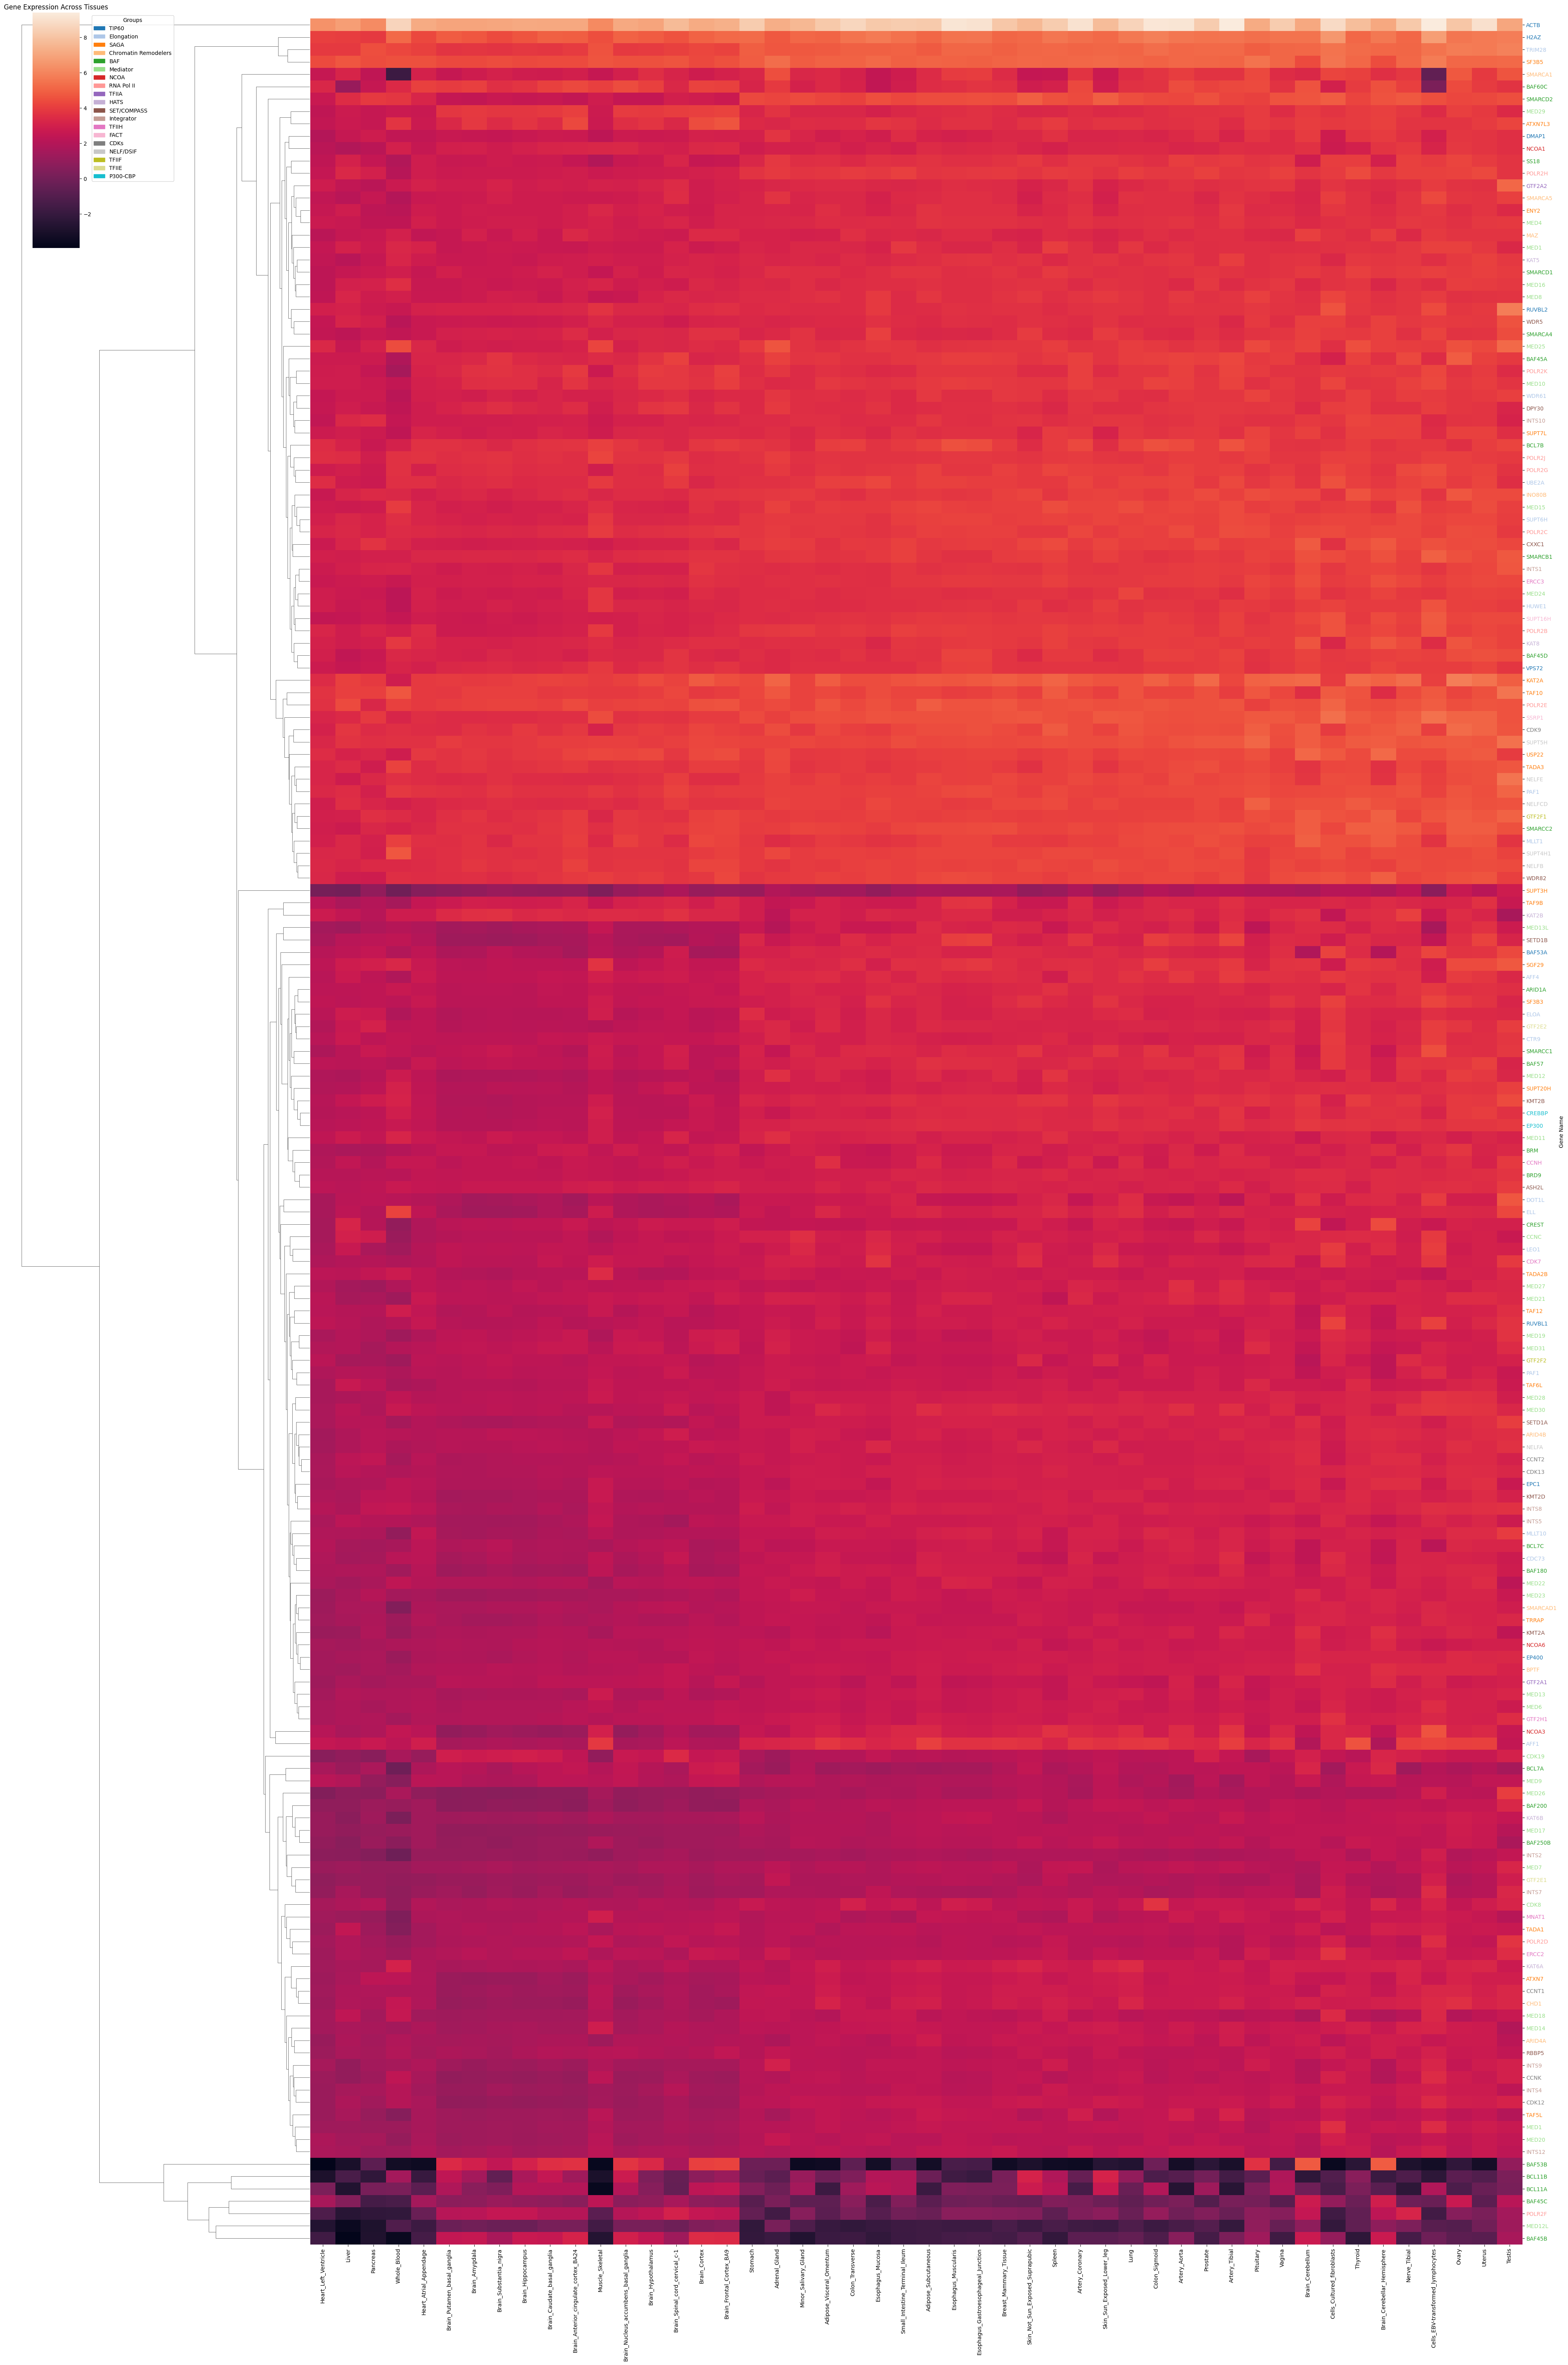

In [199]:
g = sns.clustermap(medians_gene, figsize=(40,60), col_cluster=False, dendrogram_ratio=(.2, 0), cbar_pos=(0.02, 0.9, 0.03, 0.1))
plt.title("Gene Expression Across Tissues", loc="center")

#colors y labels by complex
colorpalette = "tab20"
numcolors = len(grouped_single_complex)
color_i = 0
color_dict = {}
for val,label in enumerate(g.ax_heatmap.yaxis.get_majorticklabels()):
    group = get_one_complex(label.get_text())
    if group in color_dict.keys():
        group_label = color_dict[group]
        label.set_color(sns.color_palette(colorpalette)[group_label])
    else:
        label.set_color(sns.color_palette(colorpalette)[color_i])
        color_dict[group] = color_i
        color_i += 1

legend_handles = [mpatches.Patch(color=sns.color_palette(colorpalette)[color], label=group) for group, color in color_dict.items()]
plt.legend(handles=legend_handles, title="Groups", bbox_to_anchor=(1.2, 1), loc='upper left')

plt.show()

g.savefig("figures/medianexpression_complex.png")

In [ ]:
%% skip
#Make plots for each complex

def makeclustermap(complex):
    grouponly = grouped_single_complex[grouped_single_complex["Complex"] == complex].join(medians_gene).drop("Complex", axis=1)
    g = sns.clustermap(grouponly, figsize=(40, 50), cbar_pos=(0.02, 0.9, 0.03, 0.1))
    plt.title("Gene Expression Across Tissues", loc="center")
    g.savefig("figures/clustercomplex/{0}_medianexpression_complex.png".format(complex.replace("/", "")))

for complex in grouped_single_complex["Complex"].unique():
    makeclustermap(complex)

# Own-complex Paralogs

In [11]:
has_paralog = cofactors[[pd.notna(x) for x in cofactors["Own-complex paralog"]]]
has_paralog_unique = has_paralog[["Gene Name", "Own-complex paralog"]].drop_duplicates()
has_paralog_unique

,Gene Name,Own-complex paralog
3,BCL11A,[BCL11B]
6,BCL11B,[BCL11A]
9,BAF60A,[BAF60B]
10,BAF60A,[BAF60C]
12,BAF60B,[BAF60A]
14,BAF250A,[BAF250B]
19,BAF45A,[BAF45D]
21,BAF45D,[BAF45A]
27,BRG1,[BRM]
41,BCL7A,"[BCL7B, BCL7C]"


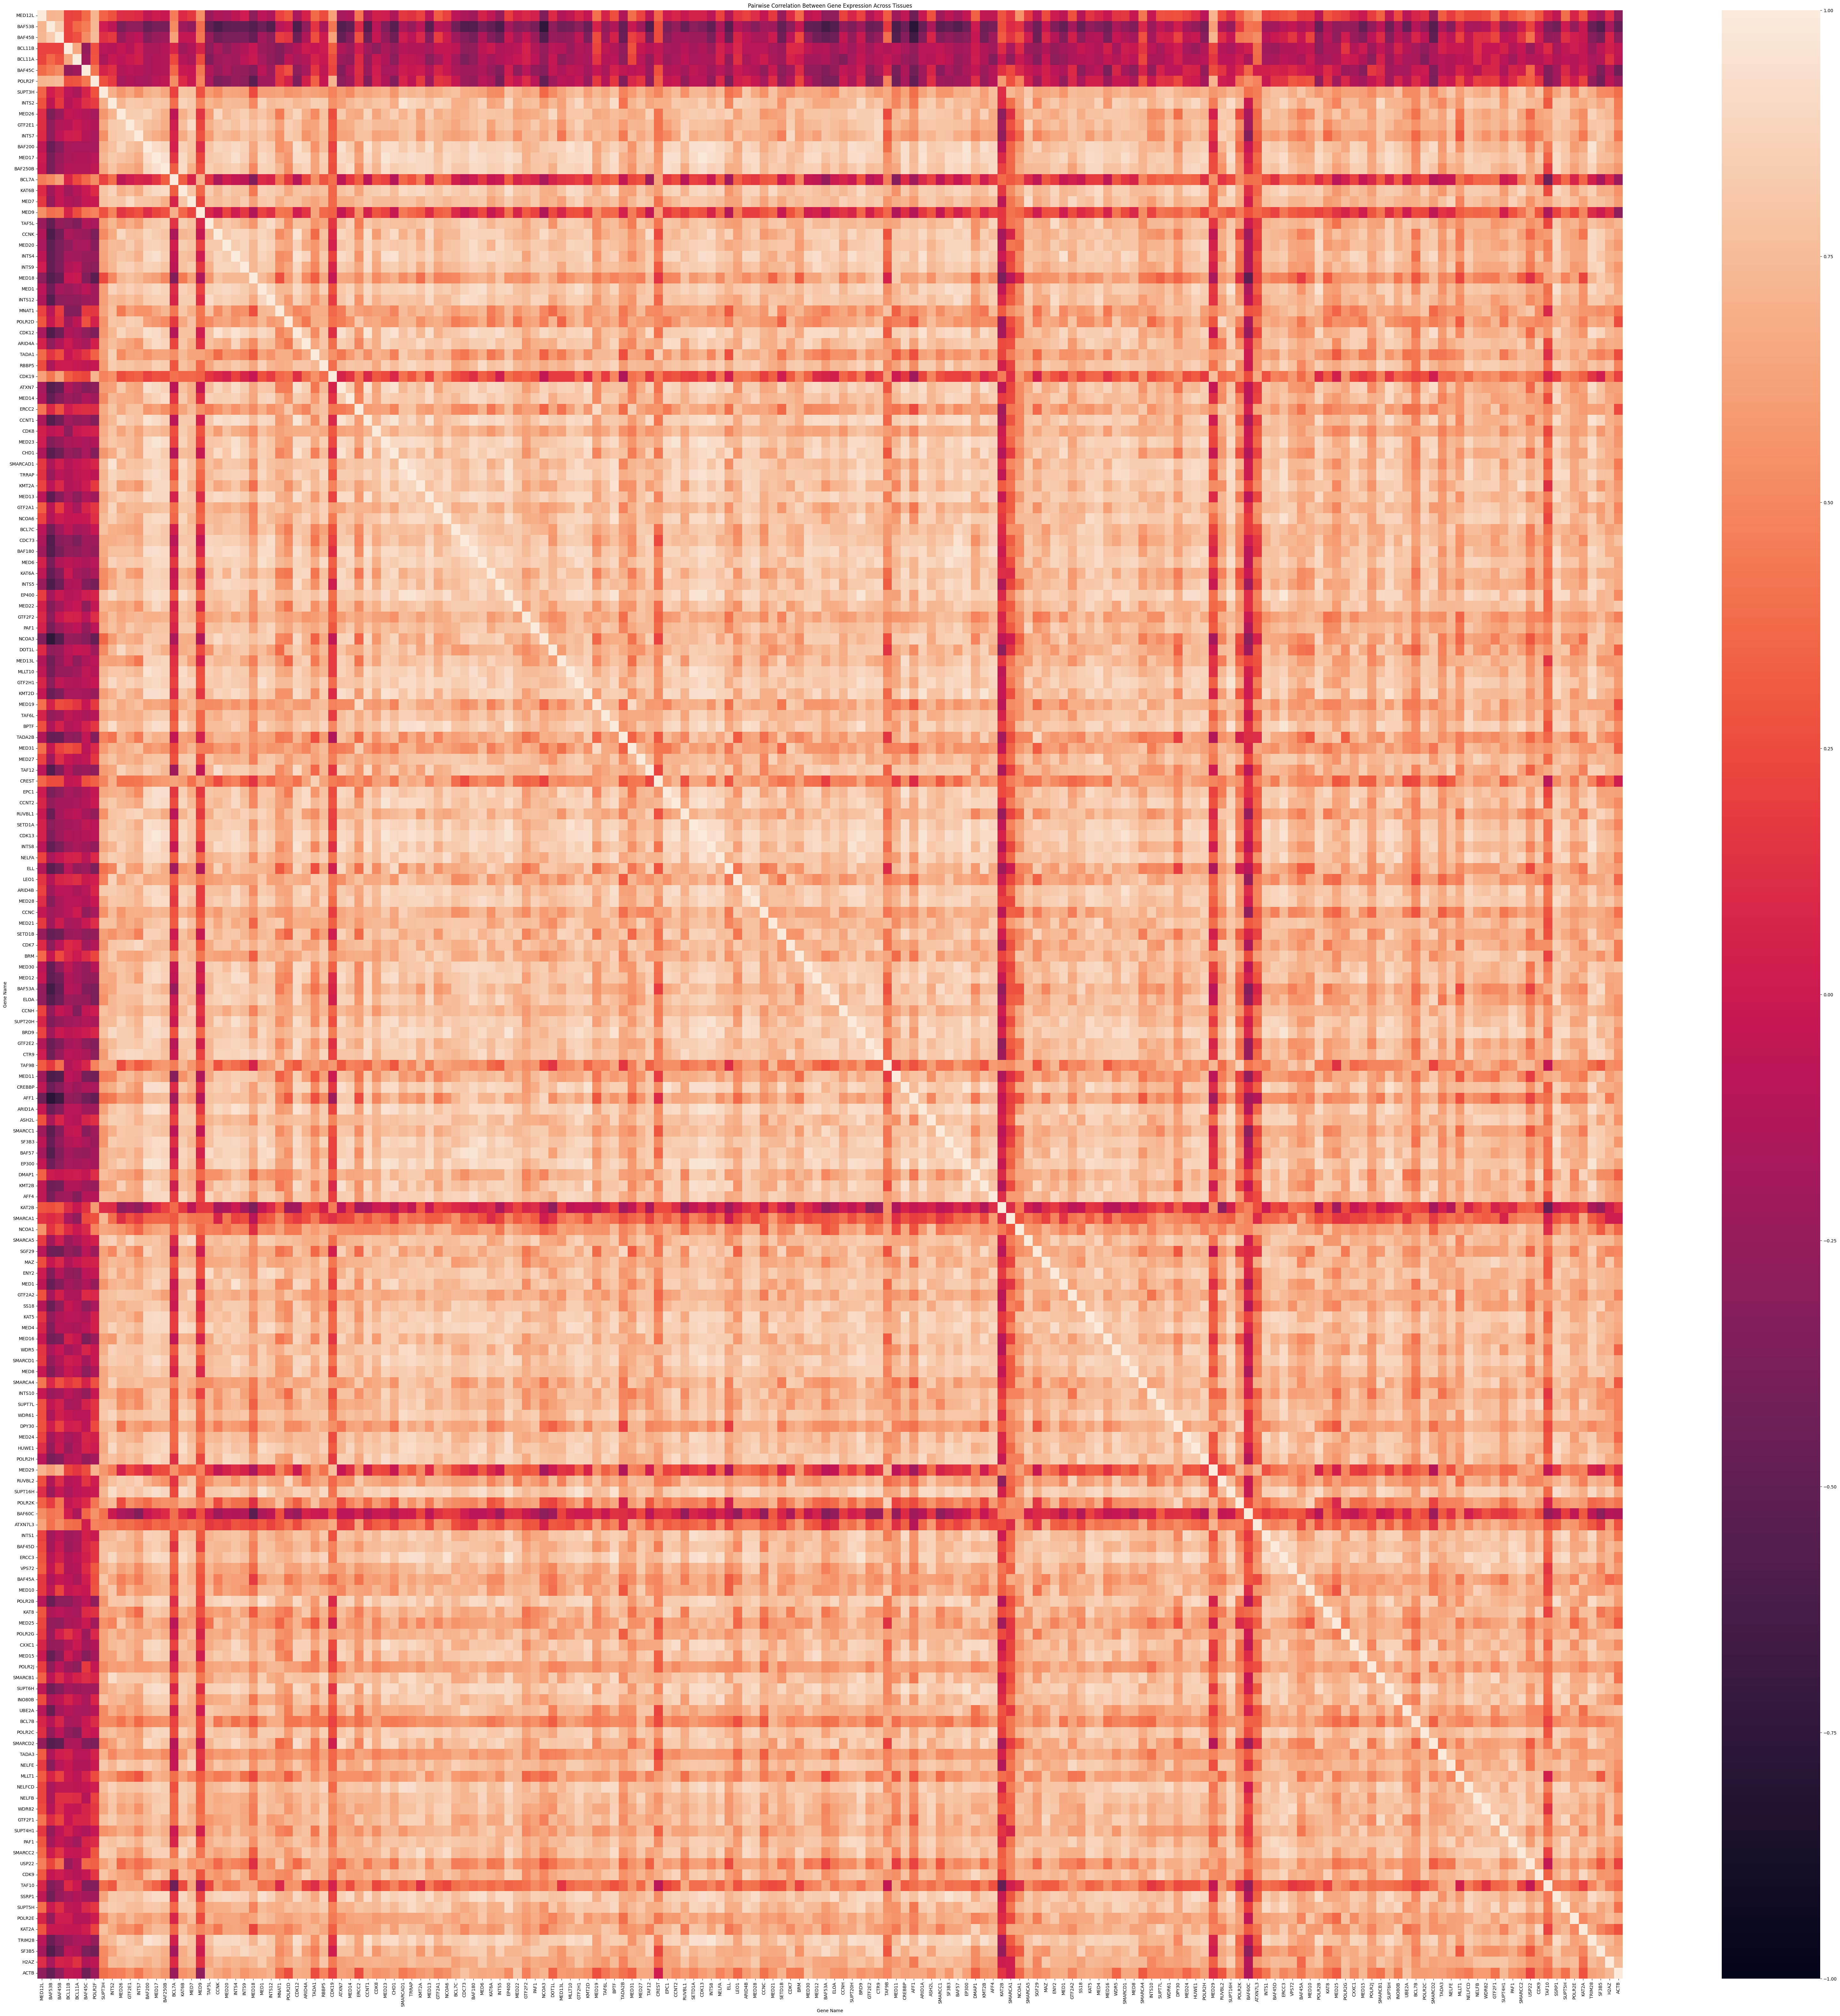

In [ ]:
genecorrelation = medians_gene.T.corr()
plt.figure(figsize=(80, 80))
sns.heatmap(genecorrelation, vmin=-1, vmax=1)
plt.title("Pairwise Correlation Between Gene Expression Across Tissues")
plt.savefig("figures/mediangeneexpressioncorrelation.png")

In [ ]:
#For each for in has_paralgog, look at correlation in expression data

paralog_corrs = pd.DataFrame({"GeneA": [], "GeneB": [], "Corr": []})

for i in range(len(has_paralog_unique)):
    row = has_paralog_unique.iloc[i]
    genea = row["Gene Name"]
    geneb = re.match("\[(.*)\]", row["Own-complex paralog"])[1]
    try:
        corr = np.round(genecorrelation[genea][geneb], 3)
        
    except:
        corr = np.NaN
        print(genea, geneb)

    paralog_corrs.loc[i] = [genea, geneb, corr]
    

paralog_corrs.sort_values("Corr", ascending=False)

BAF60A BAF60B
BAF60A BAF60C
BAF60B BAF60A
BAF250A BAF250B
BRG1 BRM
BCL7A BCL7B, BCL7C
BCL7B BCL7A, BCL7C
BCL7C BCL7A, BCL7B
BAF60C BAF60A
BAF250B BAF250A
BRM BRG1
MED12 MED12K


,GeneA,GeneB,Corr
18,MED13,MED13L,0.854
21,MED13L,MED13,0.854
6,BAF45A,BAF45D,0.710
7,BAF45D,BAF45A,0.710
0,BCL11A,BCL11B,0.663
1,BCL11B,BCL11A,0.663
15,BAF45B,BAF45C,0.520
16,BAF45C,BAF45B,0.520
19,CDK8,CDK19,0.298
22,CDK19,CDK8,0.298


In [ ]:
#Get all pairwise correlations

genecorrelation = medians_gene.T.corr()
correlation_flat = pd.DataFrame(genecorrelation.stack())
correlation_flat.index.names = ["Gene A", "Gene B"]
correlation_flat = correlation_flat.reset_index().drop_duplicates()

#Drops self pairs and redundant pairs
correlation_flat = correlation_flat[correlation_flat["Gene A"] != correlation_flat["Gene B"]]
correlation_flat["Pair"] = correlation_flat.apply(lambda row: tuple(sorted([row["Gene A"], row["Gene B"]])), axis=1)
correlation_flat = correlation_flat.drop_duplicates(subset="Pair").drop(columns="Pair")

correlation_flat = correlation_flat.rename({0: "Correlation"}, axis=1)
correlation_flat = correlation_flat.sort_values("Correlation", ascending=False)
correlation_flat.to_csv("helperfiles/pairwisecorrelationmedian.csv")

correlation_flat.head()

,Gene A,Gene B,Correlation
9681,EP400,ERCC3,0.978064
2415,MED17,CDK13,0.977570
7095,MED23,CDK13,0.975631
5257,CDK12,CCNT1,0.974376
13856,INTS8,TRIM28,0.972171


In [ ]:
#Check if genes are from the same complex
corr_mapper = merged.groupby("Gene Name").agg(list)[["Complex", "Subcomplex or Module"]]

def get_complex(genename):
    complexlist = corr_mapper.loc[genename]["Complex"]
    if len(complexlist) == 1:
        return complexlist[0]
    else:
        return complexlist

correlation_flat["Gene A complex"] = correlation_flat["Gene A"].apply(get_complex)
correlation_flat["Gene B complex"] = correlation_flat["Gene B"].apply(get_complex)

def samecomplex(a, b):
    if isinstance(a, str) and isinstance(b, str):
        return (a == b)
    elif isinstance(a, list):
        return b in a
    elif isinstance(b, list):
        return a in b
    

correlation_flat["Same Complex"] = correlation_flat.apply(lambda row: samecomplex(row["Gene A complex"], row["Gene B complex"]), axis=1)
correlation_flat.head()

,Gene A,Gene B,Correlation,Gene A complex,Gene B complex,Same Complex
9681,EP400,ERCC3,0.978064,"[TIP60, HATS]",TFIIH,False
2415,MED17,CDK13,0.977570,Mediator,CDKs,False
7095,MED23,CDK13,0.975631,Mediator,CDKs,False
5257,CDK12,CCNT1,0.974376,CDKs,CDKs,True
13856,INTS8,TRIM28,0.972171,Integrator,Elongation,False


In [16]:
def same_complex_corr(correlationcutoff):
    filteredcorr = correlation_flat[correlation_flat["Correlation"] > correlationcutoff]
    samecomplex = filteredcorr[filteredcorr["Same Complex"] == True]
    return np.round(len(samecomplex)/len(filteredcorr), 5), len(samecomplex), len(filteredcorr)


samecomplex = pd.DataFrame({"Cufoff": np.arange(0.5, 1, 0.05)})
samecomplex["Fraction Same"], samecomplex["Num Same"], samecomplex["Num Diff"]= zip(*samecomplex["Cufoff"].apply(same_complex_corr))

samecomplex.sort_values("Cufoff", ascending=False)

,Cufoff,Fraction Same,Num Same,Num Diff
9,0.95,0.09677,6,62
8,0.90,0.08861,70,790
7,0.85,0.08546,201,2352
6,0.80,0.08004,350,4373
5,0.75,0.08235,526,6387
4,0.70,0.08176,671,8207
3,0.65,0.08065,780,9671
2,0.60,0.08083,879,10875
1,0.55,0.08120,953,11736
0,0.50,0.08153,1008,12364


(array([2.000e+00, 2.000e+00, 9.000e+00, 1.600e+01, 4.400e+01, 3.800e+01,
        8.000e+01, 1.450e+02, 1.950e+02, 2.420e+02, 2.550e+02, 2.200e+02,
        2.290e+02, 2.200e+02, 2.910e+02, 3.020e+02, 3.900e+02, 5.630e+02,
        8.600e+02, 1.310e+03, 2.017e+03, 2.565e+03, 2.897e+03, 2.247e+03,
        6.140e+02]),
 array([-0.78553644, -0.71499241, -0.64444838, -0.57390435, -0.50336031,
        -0.43281628, -0.36227225, -0.29172822, -0.22118419, -0.15064016,
        -0.08009613, -0.0095521 ,  0.06099193,  0.13153596,  0.20207999,
         0.27262403,  0.34316806,  0.41371209,  0.48425612,  0.55480015,
         0.62534418,  0.69588821,  0.76643224,  0.83697627,  0.9075203 ,
         0.97806433]),
 <BarContainer object of 25 artists>)

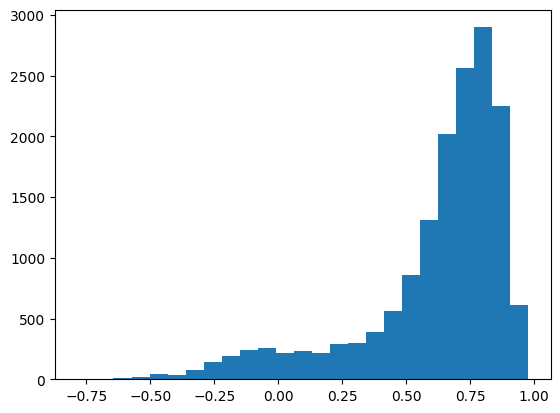

In [ ]:
plt.hist(correlation_flat["Correlation"], bins=25)

In [18]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

def aggcluster(data, numcclust):
    aggclust = AgglomerativeClustering(n_clusters=numcclust).fit(data)
    clusteringresults = pd.DataFrame({"Gene Name": medians_gene.index, "clusterID": aggclust.labels_})
    clusteringresults = clusteringresults.merge(grouped, on="Gene Name")
    return clusteringresults

def kmeans(data, numclust):
    kmeans = KMeans(n_clusters=numclust, random_state=0, n_init="auto").fit(data)
    clusteringresults = pd.DataFrame({"Gene Name": medians_gene.index, "clusterID": kmeans.labels_})
    clusteringresults = clusteringresults.merge(grouped, on="Gene Name")
    return clusteringresults

aggclustresults = aggcluster(medians_gene, 15)
kmeansclustresults = kmeans(medians_gene, 15)

In [19]:
medians_complex = medians_gene.merge(grouped, right_on="Gene Name", left_index=True).set_index("Gene Name")
medians_complex.head()

,Heart_Left_Ventricle,Liver,Pancreas,Whole_Blood,Heart_Atrial_Appendage,Brain_Putamen_basal_ganglia,Brain_Amygdala,Brain_Substantia_nigra,Brain_Hippocampus,Brain_Caudate_basal_ganglia,...,Cells_Cultured_fibroblasts,Thyroid,Brain_Cerebellar_Hemisphere,Nerve_Tibial,Cells_EBV-transformed_lymphocytes,Ovary,Uterus,Testis,Complex,Subcomplex or Module
Gene Name,,,,,,,,,,,,,,,,,,,,,
MED12L,-2.683578,-3.537102,-2.887692,-1.170979,-1.815680,-0.274991,-0.057714,-0.249820,-0.282657,0.163781,...,-2.157260,-0.611594,0.830473,0.286133,-0.872018,-0.999966,-0.062460,1.291163,[Mediator],[Kinase]
BAF53B,-3.929356,-3.005083,-0.717928,-3.302368,-3.453862,3.380787,2.973801,2.397945,3.090538,3.521083,...,-3.594699,-2.442370,4.826325,-2.839371,-3.248787,-2.231577,-3.185519,0.936985,[BAF],[nBAF]
BAF45B,-1.675923,-3.883352,-2.792813,-3.613999,-1.530129,2.424504,2.559148,1.637734,2.668494,2.527784,...,0.981892,-2.309640,2.723904,-1.466564,-0.154205,-0.739380,-0.841544,1.590806,[BAF],[nBAF]
BCL11B,-2.917501,-1.371438,-2.225458,1.524378,-1.952894,2.336865,1.483627,-0.559906,1.674500,2.476073,...,-1.083235,0.655395,-1.896056,-1.182970,-2.340836,-0.784280,-1.109120,0.273720,[BAF],"[npBAF, esBAF, nBAF]"
BCL11A,0.261290,-2.765942,0.130183,0.189820,-0.772362,1.812241,0.685463,0.384418,2.027784,1.958774,...,-1.365548,0.237475,-0.832854,-2.330144,1.871559,-1.244251,-0.297451,0.136160,[BAF],"[npBAF, esBAF, nBAF]"


BAF Complex Proteins in Brain

In [20]:
brainlabels = [x for x in medians_gene.columns.to_list() if "Brain" in x]
BAF_only = medians_complex[["BAF" in x for x in medians_complex["Complex"]]]
BAF_brain = BAF_only[brainlabels]
BAF_brain.head()

,Brain_Putamen_basal_ganglia,Brain_Amygdala,Brain_Substantia_nigra,Brain_Hippocampus,Brain_Caudate_basal_ganglia,Brain_Anterior_cingulate_cortex_BA24,Brain_Nucleus_accumbens_basal_ganglia,Brain_Hypothalamus,Brain_Spinal_cord_cervical_c-1,Brain_Cortex,Brain_Frontal_Cortex_BA9,Brain_Cerebellum,Brain_Cerebellar_Hemisphere
Gene Name,,,,,,,,,,,,,
BAF53B,3.380787,2.973801,2.397945,3.090538,3.521083,3.626611,3.758403,3.323904,1.674341,4.065548,4.136678,4.767309,4.826325
BAF45B,2.424504,2.559148,1.637734,2.668494,2.527784,3.141177,2.963357,2.432490,1.281229,3.407770,3.395952,2.709516,2.723904
BCL11B,2.336865,1.483627,-0.559906,1.674500,2.476073,1.352000,2.782053,0.333128,-0.421272,0.785520,1.218815,-2.264940,-1.896056
BCL11A,1.812241,0.685463,0.384418,2.027784,1.958774,1.997323,1.953564,0.582754,-0.466979,2.268166,2.387512,-0.179442,-0.832854
BAF45C,0.795554,0.839311,1.215192,0.972922,0.891386,0.661366,0.723349,0.868560,1.610708,0.827164,0.708168,2.772761,2.889190


In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
brain_PCA = pd.DataFrame(pca.fit_transform(BAF_brain)).rename({0: "PCA1-B", 1:"PCA2-B"}, axis=1)
brain_PCA["Gene Name"] = BAF_brain.index
brain_PCA = brain_PCA.set_index("Gene Name")

brain_PCA.head()

,PCA1-B,PCA2-B
Gene Name,,
BAF53B,-3.383028,0.646937
BAF45B,0.102750,1.342823
BCL11B,7.866250,4.459823
BCL11A,5.946421,3.007570
BAF45C,4.486562,-2.882410


In [22]:
BAF_only = medians_complex[["BAF" in x for x in medians_complex["Complex"]]]
nobrainlabels = [x for x in medians_gene.columns.to_list() if "Brain" not in x]
BAF_nobrain = BAF_only[nobrainlabels]

pca = PCA(n_components=2)
nobrain_PCA = pd.DataFrame(pca.fit_transform(BAF_nobrain)).rename({0: "PCA1-NB", 1:"PCA2-NB"}, axis=1)
nobrain_PCA["Gene Name"] = BAF_nobrain.index
nobrain_PCA = nobrain_PCA.set_index("Gene Name")

nobrain_PCA.head()

,PCA1-NB,PCA2-NB
Gene Name,,
BAF53B,28.422634,-2.440064
BAF45B,22.481137,-3.978413
BCL11B,16.343950,6.755837
BCL11A,15.000079,7.169299
BAF45C,14.094846,-4.383514


<Axes: ylabel='Gene Name'>

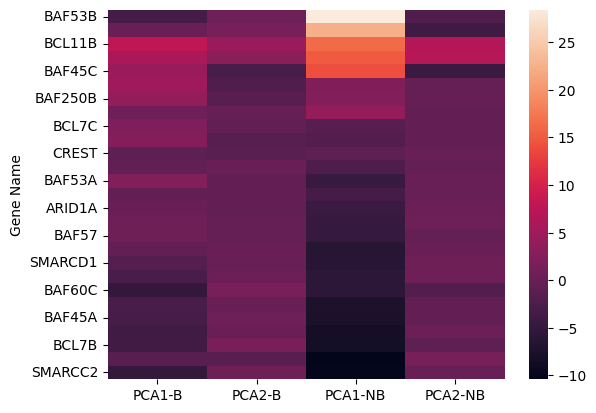

In [23]:
braionconcat = brain_PCA.merge(nobrain_PCA, left_index=True, right_index=True)
sns.heatmap(braionconcat)

In [24]:
medians_gene.columns.to_list()

['Heart_Left_Ventricle',
 'Liver',
 'Pancreas',
 'Whole_Blood',
 'Heart_Atrial_Appendage',
 'Brain_Putamen_basal_ganglia',
 'Brain_Amygdala',
 'Brain_Substantia_nigra',
 'Brain_Hippocampus',
 'Brain_Caudate_basal_ganglia',
 'Brain_Anterior_cingulate_cortex_BA24',
 'Muscle_Skeletal',
 'Brain_Nucleus_accumbens_basal_ganglia',
 'Brain_Hypothalamus',
 'Brain_Spinal_cord_cervical_c-1',
 'Brain_Cortex',
 'Brain_Frontal_Cortex_BA9',
 'Stomach',
 'Adrenal_Gland',
 'Minor_Salivary_Gland',
 'Adipose_Visceral_Omentum',
 'Colon_Transverse',
 'Esophagus_Mucosa',
 'Small_Intestine_Terminal_Ileum',
 'Adipose_Subcutaneous',
 'Esophagus_Muscularis',
 'Esophagus_Gastroesophageal_Junction',
 'Breast_Mammary_Tissue',
 'Skin_Not_Sun_Exposed_Suprapubic',
 'Spleen',
 'Artery_Coronary',
 'Skin_Sun_Exposed_Lower_leg',
 'Lung',
 'Colon_Sigmoid',
 'Artery_Aorta',
 'Prostate',
 'Artery_Tibial',
 'Pituitary',
 'Vagina',
 'Brain_Cerebellum',
 'Cells_Cultured_fibroblasts',
 'Thyroid',
 'Brain_Cerebellar_Hemisphere',